# Bilateral filter

- 모듈 임포트

In [1]:
from tqdm import tqdm
from func import *

- 상수 생성 및 데이터 임포트

In [2]:
BILATERAL_FILTER_SIZE = 7
BILATERAL_FILTER_SPACE_STD = 4
BILATERAL_FILTER_RANGE_STD = 0.05
noisy_image = cv2.imread('../img/noisy_cube.jpg', cv2.IMREAD_GRAYSCALE) / 255

- 함수 생성

In [3]:
def bilateral_filter(image, diameter, sigma_r, sigma_s):
    radius = (diameter - 1) // 2
    height, width = image.shape
    output = np.zeros(image.shape)
    for i in tqdm(range(height)):
        for j in range(width):
            pixel_sum = 0
            weight_sum = 0
            for k in range(max(0, i - radius), min(height, i + radius + 1)):
                for l in range(max(0, j - radius), min(width, j + radius + 1)):
                    weight = calculate_weight(image, i, j, k, l, sigma_r, sigma_s)
                    weight_sum += weight
                    pixel_sum += weight * image[k, l]

            output[i, j] = pixel_sum / weight_sum

    return output

- 실행

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:53<00:00,  4.77it/s]


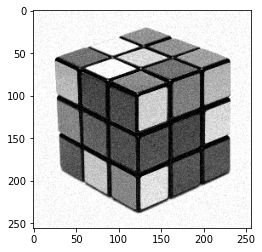

In [4]:
denoised_image = bilateral_filter(noisy_image, BILATERAL_FILTER_SIZE, BILATERAL_FILTER_SPACE_STD, BILATERAL_FILTER_RANGE_STD)##s
plt.imshow(denoised_image, cmap='gray')
plt.show()

# NLM filter

- 모듈 임포트

In [5]:
from tqdm import tqdm
from func import *

- 상수 생성 및 데이터 임포트

In [6]:
PATCH_SIZE = 5
REDUCED_PATCH_SIZE = 10
NLM_RANGE_STD_LIST = [0.05, 0.1, 0.3, 0.5, 0.7]
noisy_image = cv2.imread('../img/noisy_cube.jpg', cv2.IMREAD_GRAYSCALE) / 255

- 함수 생성

In [7]:
def nlm(image, patch_size, reduced_patch_size, sigma_r, num_neighbors=10):
    radius = patch_size // 2
    height, width = image.shape

    padded_image = np.pad(image, radius, mode='reflect')
    patches = np.zeros((height * width, patch_size ** 2,))
    for i in tqdm(range(radius, height + radius)):
        for j in range(radius, width + radius):
            patch = padded_image[i - radius:i + radius + 1, j - radius:j + radius + 1]
            patches[(i - radius) * width + (j - radius), :] = patch.flatten()

    transformed_patches = sklearn.decomposition.PCA(n_components=reduced_patch_size).fit_transform(patches)
    tree = sklearn.neighbors.BallTree(transformed_patches, leaf_size=2)
    output = np.zeros_like(image)
    for i in tqdm(range(height)):
        for j in range(width):
            patch_index = i * width + j
            patch = patches[patch_index]
            representative_patch = np.expand_dims(transformed_patches[patch_index], 0)
            _, neighbor_indices = tree.query(representative_patch, k=num_neighbors)
            neighbor_indices = neighbor_indices[0, 1:]
            pixel_indices = np.array([
                (neighbor_index // width, neighbor_index % width)
                for neighbor_index in neighbor_indices
            ])

            pixels = image[pixel_indices[:, 0], pixel_indices[:, 1]]
            weights = np.array([
                gaussian_distance(patch, patches[neighbor_index], sigma_r)
                for neighbor_index in neighbor_indices
            ])

            output[i, j] = np.sum(weights * pixels) / np.sum(weights)

    return output

- 실행

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:50<00:00,  5.08it/s]

σr: 0.05


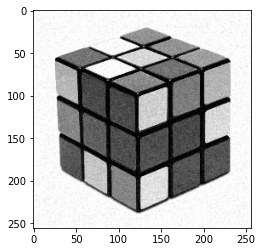

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:50<00:00,  5.02it/s]

σr: 0.1


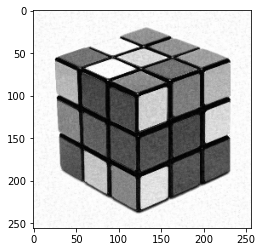

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:50<00:00,  5.02it/s]

σr: 0.3


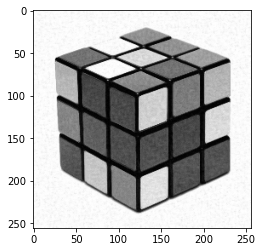

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:51<00:00,  4.93it/s]

σr: 0.5


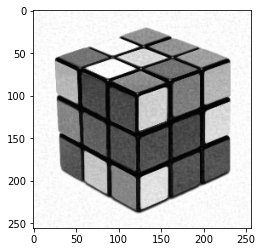

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:50<00:00,  5.09it/s]

σr: 0.7


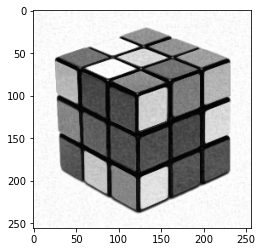

In [8]:
for RANGE in NLM_RANGE_STD_LIST:
    nlm_image = nlm(noisy_image, PATCH_SIZE, REDUCED_PATCH_SIZE, RANGE)
    plt.imshow(nlm_image, cmap='gray')
    print(f"σr: {RANGE}")
    plt.show()